# Convolutional Neural Networks (LeNet)

We are now ready to put all of the tools together
to deploy your first fully-functional convolutional neural network.
In our first encounter with image data we applied a multilayer perceptron
to pictures of clothing in the Fashion-MNIST data set.
Each image in Fashion-MNIST consisted of
a two-dimensional $28 \times 28$ matrix.
To make this data amenable to multilayer perceptrons
which anticapte receiving inputs as one-dimensional fixed-length vectors,
we first flattened each image, yielding vectors of length 784,
before processing them with a series of fully-connected layers.

Now that we have introduced convolutional layers,
we can keep the image in its original spatially-organized grid,
processing it with a series of successive convolutional layers.
Moreover, because we are using convolutional layers,
we can enjoy a considerable savings in the number of parameters required.

In this section, we will introduce one of the first
published convolutional neural networks
whose benefit was first demonstrated by Yann Lecun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images—[LeNet5](http://yann.lecun.com/exdb/lenet/).
In the 90s, their experiments with LeNet gave the first compelling evidence
that it was possible to train convolutional neural networks
by backpropagation.
Their model achieved outstanding results at the time
(only matched by Support Vector Machines at the time)
and was adopted to recognize digits for processing deposits in ATM machines.
Some ATMs still runn the code
that Yann and his colleague Leon Bottou wrote in the 1990s!

## LeNet

In a rough sense, we can think LeNet as consisting of two parts:
(i) a block of convolutional layers; and
(ii) a block of fully-connected layers.
Before getting into the weeds, let's briefly review the model in 

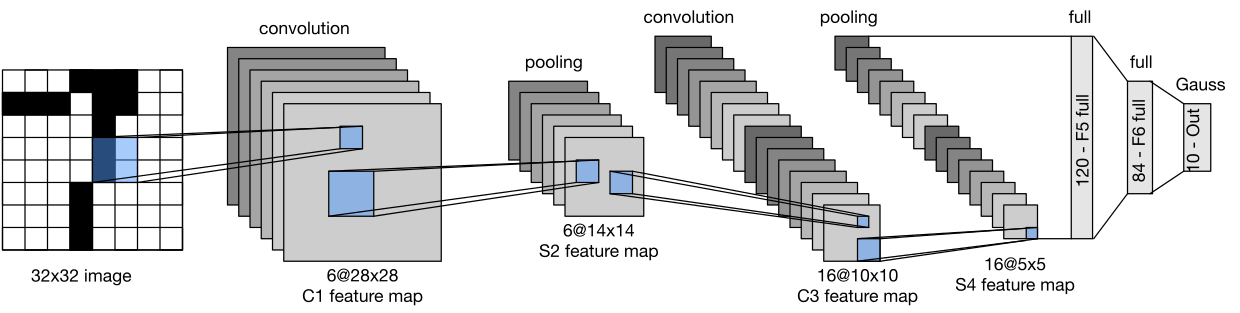

In [1]:
from IPython.display import Image
Image(filename='../img/lenet.png')

Data flow in LeNet 5. The input is a handwritten digit, the output a probabilitiy over 10 possible outcomes.

The basic units in the convolutional block are a convolutional layer
and a subsequent average pooling layer
(note that max-pooling works better,
but it had not been invented in the 90s yet).
The convolutional layer is used to recognize
the spatial patterns in the image,
such as lines and the parts of objects,
and the subsequent average pooling layer
is used to reduce the dimensionality.
The convolutional layer block is composed of
repeated stacks of these two basic units.
Each convolutional layer uses a $5\times 5$ kernel
and processes each output with a sigmoid activation function
(again, note that ReLUs are now known to work more reliably,
but had not been invented yet).
The first convolutional layer has 6 output channels,
and second convolutional layer increases channel depth further to 16.

However, coinciding with this increase in the number of channels,
the height and width are shrunk considerably.
Therefore, increasing the number of output channels
makes the parameter sizes of the two convolutional layers similar.
The two average pooling layers are of size $2\times 2$ and take stride 2
(note that this means they are non-overlapping).
In other words, the pooling layer downsamples the representation
to be precisely *one quarter* the pre-pooling size.

The convolutional block emits an output with size given by
(batch size, channel, height, width).
Before we can pass the convolutional block's output
to the fully-connected block, we must flatten
each example in the mini-batch.
In other words, we take this 4D input and tansform it into the 2D
input expected by fully-connected layers:
as a reminder, the first dimension indexes the examples in the mini-batch
and the second gives the flat vector representation of each example.
LeNet's fully-connected layer block has three fully-connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10 dimensional output layer corresponds
to the number of possible output classes.

While getting to the point
where you truly understand
what's going on inside LeNet
may have taken a bit of work,
you can see below that implementing it
in a modern deep learning library
is remarkably simple.
Again, we'll rely on the Sequential class.


In [2]:
import sys
sys.path.insert(0, '..')
import d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [3]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)
    
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

As compared to the original network, we took the liberty of replacing the Gaussian activation in the last layer by a regular linear layer, which tends to be significantly more convenient to train. Other than that, this network matches the historical definition of LeNet5. Next, we feed a single-channel example of size $28 \times 28$ into the network and perform a forward computation layer by layer printing the output shape at each layer
to make sure we understand what's happening here.

In [4]:
print(net)
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
out = net(X) 
print(out)

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten()
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)
tensor([[ 0.0937, -0.2330,  0.2207, -0.0840,  0.2129,  0.0746, -0.1463, -0.0069,
         -0.1546,  0.2027]], grad_fn=<AddmmBackward>)


Note that the height and width of the representation
at each layer throughout the convolutional block is reduced
(compared to the previous layer).
The convolutional layer uses a kernel
with a height and width of 5,
which with only $2$ pixels of padding in the first convolutional layer
and none in the second convolutional layer
leads to reductions in both height and width by 2 and 4 pixels, respectively.
Moreover each pooling layer halves the height and width.
However, as we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second layer.
Then, the fully-connected layer reduces dimensionality layer by layer,
until emitting an output that matches the number of image classes.

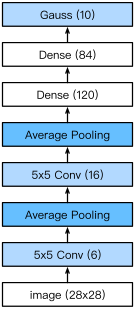

In [5]:
Image(filename="../img/lenet-vert.png")

Compressed notation for LeNet5

## Data Acquisition and Training

Now that we've implemented the model,
we might as well run some experiments
to see what we can accomplish with the LeNet model.
While it might serve nostalgia
to train LeNet on the original MNIST OCR dataset,
that dataset has become too easy,
with MLPs getting over 98% accuracy,
so it would be hard to see the benefits of convolutional networks.
Thus we will stick with Fashion-MNIST as our dataset
because while it has the same shape ($28\times28$ images),
this dataset is notably more challenging.

In [6]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While convolutional networks may have few parameters, they can still be significantly more expensive to compute than a similarly deep multilayer perceptron so if you have access to a GPU, this might be a good time to put it into action to speed up training.

Here’s a simple function that we can use to detect whether we have a GPU. In it, we try to allocate gpu0 if available using `torch.cuda.is_available()` method. Otherwise, we stick with the CPU.

In [7]:
# This function has been saved in the d2l package for future use
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
device

device(type='cuda', index=0)

For evaluation, we need to make a slight modification
to the `evaluate_accuracy` function that we described
when implementing the softmax from scratch (`chapter_softmax_scratch`).
Since the full dataset lives on the CPU,
we need to copy it to the GPU before we can compute our models.
This is accomplished via the `.to(device)` described in `chapter_use_gpu`.
Note that we accumulate the errors on the device
where the data eventually lives (in `acc`).
This avoids intermediate copy operations that might harm performance.

In [8]:
# This function has been saved in the d2l package for future use. The function
# will be gradually improved. Its complete implementation will be discussed in
# the "Image Augmentation" section
def evaluate_accuracy(data_iter, net, device):
    """Evaluate accuracy of a model on the given data set."""
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for batch in data_iter:
        features, labels = batch
        for X, y in zip(features, labels):
            # If device is the GPU, copy the data to the GPU.
            y = y.type(torch.float32)
            X, y = X.to(device), y.to(device)
            acc_sum += torch.sum((torch.argmax(net(X), dim=1).type(torch.float32) == y).detach()).float()
            n += 1
    return acc_sum.item() / n

We also need to update our training function to deal with GPUs.
Unlike `train_ch3` defined in `chapter_softmax_scratch`, we now need to move each batch of data
to our designated device (hopefully, the GPU)
prior to making the forward and backward passes.

In [9]:
# This function has been saved in the d2l package for future use
def train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr=None):
    print('training on', device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            y = y.type(torch.float32).to(device)
            train_l_sum += loss.item()
            train_acc_sum += torch.sum((torch.argmax(y_hat, dim=1).type(torch.float32) == y).detach()).float()
            n += list(y.size())[0]
        test_acc = evaluate_accuracy(test_iter, net, device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc, time.time() - start))

We initialize the model parameters on the device indicated by `device`,
this time using the Xavier initializer.
The loss function and the training algorithm
still use the cross-entropy loss function
and mini-batch stochastic gradient descent.

In [10]:
lr, num_epochs = 0.9, 5

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0091, train acc 0.098, test acc 0.100, time 10.9 sec
epoch 2, loss 0.0090, train acc 0.099, test acc 0.185, time 10.4 sec
epoch 3, loss 0.0063, train acc 0.367, test acc 0.575, time 10.4 sec
epoch 4, loss 0.0034, train acc 0.660, test acc 0.688, time 9.9 sec
epoch 5, loss 0.0027, train acc 0.727, test acc 0.695, time 10.3 sec


## Summary

* A convolutional neural network (in short, ConvNet) is a network using convolutional layers.
* In a ConvNet we alternate between convolutions, nonlinearities and often also pooling operations.
* Ultimately the resolution is reduced prior to emitting an output via one (or more) dense layers.
* LeNet was the first successful deployment of such a network.

## Exercises

1. Replace the average pooling with max pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    * Adjust the convolution window size.
    * Adjust the number of output channels.
    * Adjust the activation function (ReLU?).
    * Adjust the number of convolution layers.
    * Adjust the number of fully connected layers.
    * Adjust the learning rates and other training details (initialization, epochs, etc.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g. sweaters, coats).


## References

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.